In [1]:
from brainmri.dataset.stacker import MriStacker
from brainmri.dataset.dataset import *
from brainmri.models.arch import FPN
from brainmri.runner.train import train_model

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datetime import date

import albumentations as A
from albumentations.pytorch import ToTensor
import torch
import torch.nn as nn

import segmentation_models_pytorch as smp

In [2]:
config = {
     'make_stacks': True,
     'stack_size': 3,
     'data_dir': './data/lgg-mri-segmentation/kaggle_3m/',
     'out_dir': './data/lgg-mri-segmentation/2.5D/StackSize=3',
     'model_out_pth': './models/fpn-scratch_aug_{date}.pth',
     'augmentations': True,
     'epochs': 300,
     'batch_size': 64,
     'lr': 1e-04,
     'optimizer': 'adam',
     'device': 'cuda',
     'num_classes': 1
}

In [3]:
A.__version__

'0.2.3'

In [4]:
def get_augmentations(is_train, apply_transforms=False):
    if is_train and not apply_transforms:
        print("apply_transforms is False. Augmentations not applied")
        
    return A.Compose([
        A.RandomCrop(width = 128, height = 128, p=1.0),
        A.HorizontalFlip(p=0.5),
        A.RandomRotate90(p=0.5),
        A.Transpose(p=0.5),
        A.ShiftScaleRotate(shift_limit=0.01, scale_limit=0.04, rotate_limit=0, p=0.25),

        # Pixels
        A.RandomBrightnessContrast(p=0.5),
        A.RandomGamma(p=0.25),
        A.IAAEmboss(p=0.25),
        A.Blur(p=0.01, blur_limit = 3),

        # Affine
        A.OneOf([
            A.ElasticTransform(p=0.5, alpha=120, sigma=120 * 0.05, alpha_affine=120 * 0.03),
            A.GridDistortion(p=0.5),
            A.OpticalDistortion(p=1, distort_limit=2, shift_limit=0.5)                  
        ], p=0.8),
        ToTensor()
    ])

In [5]:
stacker = MriStacker(root_dir=config.get("data_dir"),
                         out_dir=config.get("out_dir"),
                         stack_size=config.get("stack_size"))

if config.get("make_stacks"):
    stacker.process_patients()

stacker.gen_train_val_test_split()

augs = get_augmentations(is_train=True, apply_transforms=config.get("augmentations"))
train_ds = BrainMriSegmentation(stacker.train_df, config.get("stack_size"),
                                transforms=get_augmentations(is_train=True, apply_transforms=config.get("augmentations")),
                                preprocessing=None)
valid_ds = BrainMriSegmentation(stacker.valid_df, config.get("stack_size"),
                                transforms=A.Compose([ToTensor()]), preprocessing=None)

train_dl = get_dataloader(train_ds, bs=config.get("batch_size"))
valid_dl = get_dataloader(valid_ds, bs=config.get("batch_size"))


model = FPN(3)

optimizer = torch.optim.Adam(model.parameters(), lr=config.get("lr"))

if torch.cuda.device_count() > 1 and config.get("device") == "cuda":
    print("Let's use", torch.cuda.device_count(), "GPUs!")
    model = nn.DataParallel(model)
    model = model.cuda()

loss = smp.utils.losses.DiceLoss()
metrics = [smp.utils.metrics.IoU(threshold=0.5), smp.utils.metrics.Fscore(threshold=0.5)]

train_epoch = smp.utils.train.TrainEpoch(
    model,
    loss=loss,
    metrics=metrics,
    optimizer=optimizer,
    device=config.get("device"),
    verbose=True
)

valid_epoch = smp.utils.train.ValidEpoch(
    model,
    loss=loss,
    metrics=metrics,
    device=config.get("device"),
    verbose=True
)

train_loss, valid_loss, train_fscore, valid_fscore, train_iou, valid_iou = [], [], [], [], [], []

max_score = 0
for i in range(0, config.get("epochs")):
    print('\nEpoch: {}'.format(i))
    train_logs = train_epoch.run(train_dl)
    valid_logs = valid_epoch.run(valid_dl)

    if max_score < valid_logs["fscore"]:
        max_score = valid_logs["fscore"]
        torch.save(model, config.get("model_out_pth").format(date=str(date.today())))
        print("Model saved!")

    train_loss.append(train_logs["dice_loss"])
    valid_loss.append(valid_logs["dice_loss"])
    train_fscore.append(train_logs["fscore"])
    valid_fscore.append(valid_logs["fscore"])
    train_iou.append(train_logs["iou_score"])
    valid_iou.append(valid_logs["iou_score"])  



Let's use 2 GPUs!

Epoch: 0
valid: 100%|██████████| 10/10 [00:02<00:00,  4.29it/s, dice_loss - 0.6516, iou_score - 0.2276, fscore - 0.3616]
Model saved!

Epoch: 1
valid: 100%|██████████| 10/10 [00:02<00:00,  4.23it/s, dice_loss - 0.6081, iou_score - 0.2519, fscore - 0.3991]
Model saved!

Epoch: 2
valid: 100%|██████████| 10/10 [00:02<00:00,  4.31it/s, dice_loss - 0.59, iou_score - 0.264, fscore - 0.4128]  
Model saved!

Epoch: 3
valid: 100%|██████████| 10/10 [00:02<00:00,  4.28it/s, dice_loss - 0.5429, iou_score - 0.3018, fscore - 0.4607]
Model saved!

Epoch: 4
valid: 100%|██████████| 10/10 [00:02<00:00,  4.26it/s, dice_loss - 0.6615, iou_score - 0.2097, fscore - 0.3448]

Epoch: 5
valid: 100%|██████████| 10/10 [00:02<00:00,  4.22it/s, dice_loss - 0.5242, iou_score - 0.3232, fscore - 0.4859]
Model saved!

Epoch: 6
valid: 100%|██████████| 10/10 [00:02<00:00,  4.25it/s, dice_loss - 0.5145, iou_score - 0.336, fscore - 0.4988]
Model saved!

Epoch: 7
valid: 100%|██████████| 10/10 [00:02<00:00

valid: 100%|██████████| 10/10 [00:02<00:00,  3.56it/s, dice_loss - 0.3266, iou_score - 0.5557, fscore - 0.6866]

Epoch: 35
valid: 100%|██████████| 10/10 [00:02<00:00,  3.89it/s, dice_loss - 0.2618, iou_score - 0.6056, fscore - 0.7529]
Model saved!

Epoch: 36
valid: 100%|██████████| 10/10 [00:02<00:00,  3.87it/s, dice_loss - 0.2801, iou_score - 0.5824, fscore - 0.7351]

Epoch: 37
valid: 100%|██████████| 10/10 [00:02<00:00,  3.78it/s, dice_loss - 0.2984, iou_score - 0.5536, fscore - 0.7089]

Epoch: 38
valid: 100%|██████████| 10/10 [00:02<00:00,  3.85it/s, dice_loss - 0.2998, iou_score - 0.5655, fscore - 0.7207]

Epoch: 39
valid: 100%|██████████| 10/10 [00:02<00:00,  3.87it/s, dice_loss - 0.2467, iou_score - 0.6145, fscore - 0.7601]
Model saved!

Epoch: 40
valid: 100%|██████████| 10/10 [00:02<00:00,  3.86it/s, dice_loss - 0.2556, iou_score - 0.6127, fscore - 0.7578]

Epoch: 41
valid: 100%|██████████| 10/10 [00:02<00:00,  3.89it/s, dice_loss - 0.2732, iou_score - 0.5876, fscore - 0.7396]



valid: 100%|██████████| 10/10 [00:02<00:00,  3.92it/s, dice_loss - 0.227, iou_score - 0.6446, fscore - 0.7831]
Model saved!

Epoch: 69
valid: 100%|██████████| 10/10 [00:02<00:00,  4.00it/s, dice_loss - 0.4145, iou_score - 0.4439, fscore - 0.6076]

Epoch: 70
valid: 100%|██████████| 10/10 [00:02<00:00,  3.95it/s, dice_loss - 0.252, iou_score - 0.6132, fscore - 0.7569]

Epoch: 71
valid: 100%|██████████| 10/10 [00:02<00:00,  3.86it/s, dice_loss - 0.2814, iou_score - 0.574, fscore - 0.7286]

Epoch: 72
valid: 100%|██████████| 10/10 [00:02<00:00,  3.92it/s, dice_loss - 0.32, iou_score - 0.5305, fscore - 0.692]  

Epoch: 73
valid: 100%|██████████| 10/10 [00:02<00:00,  3.99it/s, dice_loss - 0.3314, iou_score - 0.5155, fscore - 0.6786]

Epoch: 74
valid: 100%|██████████| 10/10 [00:02<00:00,  3.93it/s, dice_loss - 0.2998, iou_score - 0.5554, fscore - 0.7128]

Epoch: 75
valid: 100%|██████████| 10/10 [00:02<00:00,  3.92it/s, dice_loss - 0.3169, iou_score - 0.5322, fscore - 0.6935]

Epoch: 76
valid: 

valid: 100%|██████████| 10/10 [00:02<00:00,  3.89it/s, dice_loss - 0.2593, iou_score - 0.6, fscore - 0.7494]  

Epoch: 104
valid: 100%|██████████| 10/10 [00:02<00:00,  3.89it/s, dice_loss - 0.2744, iou_score - 0.5909, fscore - 0.7328]

Epoch: 105
valid: 100%|██████████| 10/10 [00:02<00:00,  3.97it/s, dice_loss - 0.2444, iou_score - 0.6171, fscore - 0.7625]

Epoch: 106
valid: 100%|██████████| 10/10 [00:02<00:00,  3.81it/s, dice_loss - 0.299, iou_score - 0.5584, fscore - 0.7156]

Epoch: 107
valid: 100%|██████████| 10/10 [00:02<00:00,  4.06it/s, dice_loss - 0.2479, iou_score - 0.618, fscore - 0.7631]

Epoch: 108
valid: 100%|██████████| 10/10 [00:02<00:00,  3.85it/s, dice_loss - 0.2127, iou_score - 0.6597, fscore - 0.7942]

Epoch: 109
valid: 100%|██████████| 10/10 [00:02<00:00,  3.75it/s, dice_loss - 0.2214, iou_score - 0.6473, fscore - 0.7851]

Epoch: 110
valid: 100%|██████████| 10/10 [00:02<00:00,  4.00it/s, dice_loss - 0.2497, iou_score - 0.6101, fscore - 0.7564]

Epoch: 111
valid: 100%

valid: 100%|██████████| 10/10 [00:02<00:00,  4.07it/s, dice_loss - 0.2559, iou_score - 0.6028, fscore - 0.7512]

Epoch: 138
valid: 100%|██████████| 10/10 [00:02<00:00,  3.69it/s, dice_loss - 0.22, iou_score - 0.6479, fscore - 0.786]  

Epoch: 139
valid: 100%|██████████| 10/10 [00:02<00:00,  3.90it/s, dice_loss - 0.1725, iou_score - 0.7132, fscore - 0.8319]
Model saved!

Epoch: 140
valid: 100%|██████████| 10/10 [00:02<00:00,  3.85it/s, dice_loss - 0.243, iou_score - 0.6191, fscore - 0.7643]

Epoch: 141
valid: 100%|██████████| 10/10 [00:03<00:00,  3.33it/s, dice_loss - 0.2104, iou_score - 0.6644, fscore - 0.7972]

Epoch: 142
valid: 100%|██████████| 10/10 [00:02<00:00,  3.92it/s, dice_loss - 0.2646, iou_score - 0.5933, fscore - 0.7434]

Epoch: 143
valid: 100%|██████████| 10/10 [00:02<00:00,  3.84it/s, dice_loss - 0.1808, iou_score - 0.7013, fscore - 0.8241]

Epoch: 144
valid: 100%|██████████| 10/10 [00:02<00:00,  3.91it/s, dice_loss - 0.2252, iou_score - 0.6411, fscore - 0.7799]

Epoch: 1

valid: 100%|██████████| 10/10 [00:02<00:00,  3.90it/s, dice_loss - 0.2941, iou_score - 0.5602, fscore - 0.7172]

Epoch: 173
valid: 100%|██████████| 10/10 [00:02<00:00,  4.01it/s, dice_loss - 0.204, iou_score - 0.6703, fscore - 0.802] 

Epoch: 174
valid: 100%|██████████| 10/10 [00:02<00:00,  4.00it/s, dice_loss - 0.2066, iou_score - 0.6673, fscore - 0.8]  

Epoch: 175
valid: 100%|██████████| 10/10 [00:02<00:00,  3.94it/s, dice_loss - 0.233, iou_score - 0.6308, fscore - 0.7725]

Epoch: 176
valid: 100%|██████████| 10/10 [00:02<00:00,  3.88it/s, dice_loss - 0.1905, iou_score - 0.6881, fscore - 0.8145]

Epoch: 177
valid: 100%|██████████| 10/10 [00:02<00:00,  3.65it/s, dice_loss - 0.1846, iou_score - 0.6953, fscore - 0.8196]

Epoch: 178
valid: 100%|██████████| 10/10 [00:02<00:00,  3.91it/s, dice_loss - 0.2041, iou_score - 0.6698, fscore - 0.7998]

Epoch: 179
valid: 100%|██████████| 10/10 [00:02<00:00,  3.90it/s, dice_loss - 0.2129, iou_score - 0.656, fscore - 0.7915]

Epoch: 180
valid: 100%|

valid: 100%|██████████| 10/10 [00:02<00:00,  3.88it/s, dice_loss - 0.2279, iou_score - 0.6356, fscore - 0.7763]

Epoch: 207
valid: 100%|██████████| 10/10 [00:02<00:00,  3.87it/s, dice_loss - 0.1764, iou_score - 0.7051, fscore - 0.8264]

Epoch: 208
valid: 100%|██████████| 10/10 [00:02<00:00,  3.84it/s, dice_loss - 0.2142, iou_score - 0.6556, fscore - 0.7914]

Epoch: 209
valid: 100%|██████████| 10/10 [00:02<00:00,  3.84it/s, dice_loss - 0.1827, iou_score - 0.6986, fscore - 0.8221]

Epoch: 210
valid: 100%|██████████| 10/10 [00:02<00:00,  3.87it/s, dice_loss - 0.2155, iou_score - 0.6532, fscore - 0.7893]

Epoch: 211
valid: 100%|██████████| 10/10 [00:02<00:00,  3.91it/s, dice_loss - 0.1841, iou_score - 0.6964, fscore - 0.8207]

Epoch: 212
valid: 100%|██████████| 10/10 [00:02<00:00,  3.88it/s, dice_loss - 0.1773, iou_score - 0.7053, fscore - 0.8261]

Epoch: 213
valid: 100%|██████████| 10/10 [00:02<00:00,  3.84it/s, dice_loss - 0.1839, iou_score - 0.6967, fscore - 0.821]

Epoch: 214
valid: 10

valid: 100%|██████████| 10/10 [00:02<00:00,  3.95it/s, dice_loss - 0.2365, iou_score - 0.626, fscore - 0.7691]

Epoch: 242
valid: 100%|██████████| 10/10 [00:02<00:00,  3.91it/s, dice_loss - 0.1995, iou_score - 0.6738, fscore - 0.8042]

Epoch: 243
valid: 100%|██████████| 10/10 [00:02<00:00,  3.72it/s, dice_loss - 0.1902, iou_score - 0.6866, fscore - 0.8124]

Epoch: 244
valid: 100%|██████████| 10/10 [00:02<00:00,  3.95it/s, dice_loss - 0.301, iou_score - 0.5483, fscore - 0.7055]

Epoch: 245
valid: 100%|██████████| 10/10 [00:02<00:00,  3.73it/s, dice_loss - 0.1905, iou_score - 0.6883, fscore - 0.814]

Epoch: 246
valid: 100%|██████████| 10/10 [00:02<00:00,  3.91it/s, dice_loss - 0.1768, iou_score - 0.7065, fscore - 0.8269]

Epoch: 247
valid: 100%|██████████| 10/10 [00:02<00:00,  3.85it/s, dice_loss - 0.1883, iou_score - 0.6885, fscore - 0.8148]

Epoch: 248
valid: 100%|██████████| 10/10 [00:02<00:00,  3.88it/s, dice_loss - 0.2483, iou_score - 0.6115, fscore - 0.7574]

Epoch: 249
valid: 100%

valid: 100%|██████████| 10/10 [00:02<00:00,  3.77it/s, dice_loss - 0.2322, iou_score - 0.6325, fscore - 0.7728]

Epoch: 276
valid: 100%|██████████| 10/10 [00:02<00:00,  3.86it/s, dice_loss - 0.1856, iou_score - 0.6934, fscore - 0.8178]

Epoch: 277
valid: 100%|██████████| 10/10 [00:02<00:00,  3.87it/s, dice_loss - 0.1619, iou_score - 0.7269, fscore - 0.8412]

Epoch: 278
valid: 100%|██████████| 10/10 [00:02<00:00,  4.11it/s, dice_loss - 0.1807, iou_score - 0.6988, fscore - 0.8221]

Epoch: 279
valid: 100%|██████████| 10/10 [00:02<00:00,  3.77it/s, dice_loss - 0.1565, iou_score - 0.7348, fscore - 0.8464]

Epoch: 280
valid: 100%|██████████| 10/10 [00:02<00:00,  3.79it/s, dice_loss - 0.1588, iou_score - 0.7305, fscore - 0.8438]

Epoch: 281
valid: 100%|██████████| 10/10 [00:02<00:00,  3.89it/s, dice_loss - 0.1905, iou_score - 0.6859, fscore - 0.8132]

Epoch: 282
valid: 100%|██████████| 10/10 [00:02<00:00,  3.82it/s, dice_loss - 0.1754, iou_score - 0.7077, fscore - 0.8276]

Epoch: 283
valid: 1

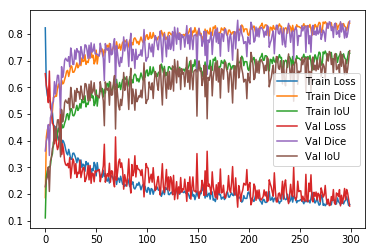

In [6]:
plt.plot(train_loss)
plt.plot(train_fscore)
plt.plot(train_iou)
plt.plot(valid_loss)
plt.plot(valid_fscore)
plt.plot(valid_iou)                                                                                

plt.legend(["Train Loss",  "Train Dice", "Train IoU", "Val Loss", "Val Dice", "Val IoU"])

In [11]:
best_model = torch.load("./models/fpn-scratch_aug_2021-08-26.pth")

In [12]:
test_ds = BrainMriSegmentation(stacker.test_df, config.get("stack_size"),
                                transforms=A.Compose([ToTensor()]))
test_dl = get_dataloader(test_ds, bs=config.get("batch_size"))

In [13]:
loss = smp.utils.losses.DiceLoss()
metrics = [smp.utils.metrics.IoU(threshold=0.5), smp.utils.metrics.Fscore(threshold=0.5)]
    
test_epoch =  smp.utils.train.ValidEpoch(
    best_model,
    loss=loss,
    metrics=metrics,
    device=config.get("device"),
    verbose=True
)

In [14]:
test_epoch.run(test_dl)

valid: 100%|██████████| 6/6 [00:01<00:00,  4.27it/s, dice_loss - 0.1611, iou_score - 0.7295, fscore - 0.8422]


{'dice_loss': 0.16113439202308655,
 'iou_score': 0.7295094728469849,
 'fscore': 0.8422158459822338}